#### TODOs

- [x] Compute accuracy and total loss in training loop 
- [x] At the end of training, plot losses and accuracies to pick a stopping epoch

In [64]:
import string 
import numpy as np
from data import get_train_test_split
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
class Linear:
    """
    Linear model
    Args:
        classes (list): list of possible labels
        max_len (int): maximum length of input sequence (destination)
        vocab_size (int): number of characters in the vocabulary
    """
    def __init__(self, classes, max_len):
        self.classes = classes
        self.vocab = self.build_vocab()
        self.max_len = max_len
        
        self.w = np.ones((len(classes), max_len * len(self.vocab)))
        self.b = np.ones((len(classes), 1))
        
    
    def build_vocab(self):
        all_char = string.printable
        vocab = { "": 0, " ": 1}
        idx = 2
        for c in all_char:
            vocab[c] = idx
            idx += 1
        return vocab
    
    def encode(self, text):
        """
        Return a one hot encoded vector along one dimension (all characters are concatenated)
        """
        text = text.lower()
        token_idx = [self.vocab[c] for c in text]
        # insert padding for fixed length inputs
        token_idx += [0] * (self.max_len-len(token_idx))
        
        # convert into one hot encoded vector and concatenate along one dimension
        token = 0
        for i in token_idx:
            one_hot_encoded_vector = np.zeros((len(self.vocab), 1))
            one_hot_encoded_vector[i][0] = 1
            if type(token) == int: token = one_hot_encoded_vector 
            else: token = np.concatenate((token, one_hot_encoded_vector), axis=0)
        return token
    
    def __call__(self, text):
        x = self.encode(text)
        preds = np.dot(self.w, x) + self.b
        preds = preds.flatten()
        preds = self.softmax(preds)
        idx_pred_max = preds.index(max(preds))
        labels = {}
        for i in range(len(self.classes)):
            labels[self.classes[i]] = preds[i]
        return self.classes[idx_pred_max], labels
    
    @staticmethod
    def softmax(array):
        denominator = sum([np.exp(i) for i in array])
        return [np.exp(i) / denominator for i in array]
    
    def fit(self, dataset, epochs=1, batch_size=1, lr=0.1):
        """
        Implement stochastic gradient descent to estimate w and b parameters
        Args:
            dataset (pd.DataFrame): train dataset with columns "destination" and "code"
        """
        losses = []
        accuracies = []
        for epoch in range(epochs):
            total_loss = 0
            accuracy = 0
            
            for i in range(len(dataset)):
                text = dataset.iloc[i]["destination"]
                x = self.encode(text)
                target = dataset.iloc[i]["code"]
                
                y_true = np.zeros((len(self.classes), 1))
                y_true[self.classes.index(target)][0] = 1
                y_pred = np.dot(self.w, x) + self.b
                
                denominator = sum([np.exp(i) for i in y_pred.tolist()])
                for i in range(y_pred.size):
                    y_pred[i][0] = np.exp(y_pred[i][0]) / denominator

                # compute gradient and update parameters
                dw = -np.dot(y_true - y_pred, np.transpose(x))
                db = - (y_true - y_pred)

                self.w -= lr * dw
                self.b -= lr * db
                
                total_loss += np.sum((y_true - y_pred)**2)
                if np.argmax(y_pred) == np.argmax(y_true): accuracy += 1
            
            accuracy /= len(dataset)
            losses.append(total_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {epoch+1}/{epochs} | Accuracy: {accuracy} | Loss: {total_loss}")
        
        
        plt.rcParams['figure.figsize'] = [10, 4]
        plt.rcParams['figure.dpi'] = 100
        fig, ax = plt.subplots(1,2)
        sns.lineplot(range(epochs), losses, ax=ax[0]).set(title="Loss", xlabel="Epoch")
        sns.lineplot(range(epochs), accuracies, ax=ax[1]).set(title="Accuracy", xlabel="Epoch")
        fig.show()
        return losses, accuracies

    def eval(self, dataset):
        corrects = 0
        errors = []
        
        for i in tqdm(range(len(dataset))):
            text = dataset.iloc[i]["destination"]
            target = dataset.iloc[i]["code"]
            
            pred, _ = self(text)
            if pred == target: corrects += 1
            else: errors.append((text, target, pred))
        
        return corrects / len(dataset), errors

In [93]:
train, test = get_train_test_split()
classes = train["code"].unique().tolist()

model = Linear(classes=classes, max_len=40)

Epoch: 1/20 | Accuracy: 0.43434343434343436 | Loss: 147.30404428358418
Epoch: 2/20 | Accuracy: 0.8080808080808081 | Loss: 54.999739830423835
Epoch: 3/20 | Accuracy: 0.9141414141414141 | Loss: 30.88563332697833
Epoch: 4/20 | Accuracy: 0.9595959595959596 | Loss: 18.3574004923204
Epoch: 5/20 | Accuracy: 0.9848484848484849 | Loss: 11.998159018212535
Epoch: 6/20 | Accuracy: 0.98989898989899 | Loss: 8.339017057977474
Epoch: 7/20 | Accuracy: 0.9949494949494949 | Loss: 5.997161461584384
Epoch: 8/20 | Accuracy: 1.0 | Loss: 4.469866256612849
Epoch: 9/20 | Accuracy: 1.0 | Loss: 3.4198544133049023
Epoch: 10/20 | Accuracy: 1.0 | Loss: 2.6656452584998123
Epoch: 11/20 | Accuracy: 1.0 | Loss: 2.1148220003688554
Epoch: 12/20 | Accuracy: 1.0 | Loss: 1.707787854511986
Epoch: 13/20 | Accuracy: 1.0 | Loss: 1.4023421376792151
Epoch: 14/20 | Accuracy: 1.0 | Loss: 1.1690794287409583
Epoch: 15/20 | Accuracy: 1.0 | Loss: 0.9878000085631754
Epoch: 16/20 | Accuracy: 1.0 | Loss: 0.8445786851583739
Epoch: 17/20 | A

/home/achraf/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/achraf/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/achraf/.local/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


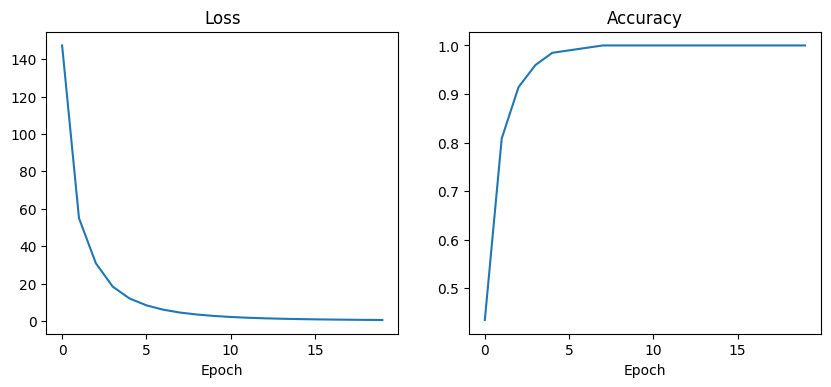

In [94]:
losses, accuracies = model.fit(train, epochs=20, lr=0.1)

In [95]:
model.eval(test)

100%|██████████| 50/50 [00:00<00:00, 2779.19it/s]


(0.76,
 [('ES CAD>FR BES', 'FRBES', 'ESSDR'),
  ('IE  DUB > ES  SDR', 'ESSDR', 'FRLEH'),
  ('FROM GBSOU TO ESSDR', 'ESSDR', 'FRLEH'),
  ('FR BOD', 'FRBOD', 'FRBES'),
  ('RU LED > ES SDR', 'ESSDR', 'BEANR'),
  ('ESALG>FRLEH', 'FRLEH', 'NLRTM'),
  ('GBSOU>ESSDR', 'ESSDR', 'FRBOD'),
  ('FR BOD > RU PRI', 'FRBOD', 'FRBES'),
  ('ITGIT=>BEANR', 'BEANR', 'NLRTM'),
  ('EG ALY>FR LEH', 'FRLEH', 'NLRTM'),
  ('ESGIJ>BEANR', 'BEANR', 'NLRTM'),
  ('BODEAUX', 'FRBOD', 'FRBES')])